In [2]:
import os
import json
import dotenv


os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "comics"

#load env from .env
dotenv.load_dotenv('../.env')

True

## 1. Utils functions
### 1.1 Structrued Output parser

In [30]:
import re
from langchain_core.output_parsers.base import BaseOutputParser
from langchain_core.runnables import RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from json import JSONDecodeError

def dict_to_obj(json_str:dict, target:object):
    return target.parse_obj(json_str)


class CustJsonOuputParser(BaseOutputParser[str]): 
    verbose :bool = Field( default=True)

    def parse(self, text: str) -> str:
        if self.verbose:
            print(text)
        pattern = r"<answer>(.*?)</answer>"
        match = re.search(pattern, text, re.DOTALL)
        if match:
            text = match.group(1)
            # print(text)
            # text = text.replace('[','(').replace(']',')') ##避免跟sentiment的格式冲突
        else:
            return {'answer':"no"}    
        new_dict = json.loads(text.replace('\n','  '))
        
        return new_dict

    @property
    def _type(self) -> str:
        return "cust_output_parser"
    
outparser = CustJsonOuputParser(verbose=False)

### 1.2 LLM models

In [4]:
from langchain_aws import ChatBedrock

from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

llm_sonnet = ChatBedrock(model_id="anthropic.claude-3-sonnet-20240229-v1:0",
                  model_kwargs={"temperature": 0.8,
                                "top_k":250,
                                "max_tokens": 4096,
                                "top_p":0.9,
                                "stop_sequences":['</invoke>','</error>']
                               },
                  streaming=False,
                #   callbacks=[StreamingStdOutCallbackHandler()]
                )

llm_haiku = ChatBedrock(model_id="anthropic.claude-3-haiku-20240307-v1:0",
                  model_kwargs={"temperature": 0.8,
                                "top_k":250,
                                "max_tokens": 4096,
                                "top_p":0.9,
                                "stop_sequences":['</invoke>','</error>']
                               },
                  streaming=True,
                  # callbacks=[StreamingStdOutCallbackHandler()]
                  )

llm_llama = ChatBedrock(model_id="meta.llama3-70b-instruct-v1:0",
                  model_kwargs={"temperature": 0.5,
                                "max_gen_len": 2048,
                                "top_p":0.9,
                                # "stop_sequences":['</invoke>','</error>']
                               },
                  streaming=True,
                  # callbacks=[StreamingStdOutCallbackHandler()]
                  )

llm_cr = ChatBedrock(model_id="cohere.command-r-v1:0",
                  model_kwargs={"temperature": 0.8,
                                "top_k":250,
                                "max_tokens": 4096,
                                "top_p":0.5,
                                "stop_sequences":['</invoke>','</error>']
                               },
                  streaming=True,
                  # callbacks=[StreamingStdOutCallbackHandler()]
                  )

llm = llm_haiku


In [5]:
# llm_llama.invoke("[USER] hello [USER] ")
# llm_cr.invoke("hello")

### 1.3 Image Generation model invoke code

In [164]:
import base64
import io
import json
import boto3
from PIL import Image
from botocore.exceptions import ClientError
from enum import Enum


class StyleEnum(Enum):
    Photographic = "photographic"
    Tile_texture = "tile-texture"
    Digital_art = "digital-art"
    Origami = "origami"
    Modeling_compound = "modeling-compound"
    Anime = "anime"
    Cinematic = "cinematic"
    Model_3D = "3d-model"
    Comicbook = "comic-book"
    Enhance = "enhance"
    
class ImageError(Exception):
    "Custom exception for errors returned by SDXL"
    def __init__(self, message):
        self.message = message


class ImageGenerator(BaseModel):
    model_id: str = Field(default="stability.stable-diffusion-xl-v1")
    cfg_scale: int = Field( default=7)
    steps:int = Field( default=50)
    samples:int = Field( default=1)
    
    def _generate(self,model_id, body):
        """
        Generate an image using SDXL 1.0 on demand.
        Args:
            model_id (str): The model ID to use.
            body (str) : The request body to use.
        Returns:
            image_bytes (bytes): The image generated by the model.
        """

        # logger.info("Generating image with SDXL model %s", model_id)

        bedrock = boto3.client(service_name='bedrock-runtime')
    
        accept = "application/json"
        content_type = "application/json"

        response = bedrock.invoke_model(
            body=body, modelId=model_id, accept=accept, contentType=content_type
        )
        response_body = json.loads(response.get("body").read())

        base64_image = response_body.get("artifacts")[0].get("base64")
        base64_bytes = base64_image.encode('ascii')
        image_bytes = base64.b64decode(base64_bytes)

        finish_reason = response_body.get("artifacts")[0].get("finishReason")

        if finish_reason == 'ERROR' or finish_reason == 'CONTENT_FILTERED':
            raise ImageError(f"Image generation error. Error code is {finish_reason}")


        # logger.info("Successfully generated image withvthe SDXL 1.0 model %s", model_id)

        return image_bytes

    def generate_image( self,prompt,seed=0,style_preset=StyleEnum.Photographic.value):
        if self.model_id.startswith('stability'):
            body=json.dumps({
                "text_prompts": [
                {
                "text": prompt
                }
            ],
            "cfg_scale": self.cfg_scale,
            "seed": seed,
            "steps": self.steps,
            "samples" : self.samples,
            "style_preset" : style_preset
            })
        else:
            body = json.dumps({
            "taskType": "TEXT_IMAGE",
            "textToImageParams": {
                "text": prompt
            },
            "imageGenerationConfig": {
                "numberOfImages": 1,
                "height": 512,
                "width": 512,
                "cfgScale": self.cfg_scale,
                "seed": seed
            }
            })
        print(body)
        image= None
        try:
            image_bytes=self._generate(model_id = self.model_id,
                                    body = body)
            image = Image.open(io.BytesIO(image_bytes))

        except ClientError as err:
            message=err.response["Error"]["Message"]
            # logger.error("A client error occurred: %s", message)
            print("A client error occured: " +format(message))
        except Exception as err:
            print(err)
        finally:
            return image

- test generation

In [32]:
# model_id='amazon.titan-image-generator-v1'
model_id='stability.stable-diffusion-xl-v1'
image_generator = ImageGenerator(model_id=model_id)
# # test for image generator
# img = image_generator.generate_image(
#   "A highly detailed, a pole write placeholder, 4k, cinematic lighting, digital art"
# )

# img.save('./images/placeholder.png')

### 1.4 Agent Roles settings

In [33]:
company_setting = """You are woking in a cartoon studio, the best and creative cartoon studio in the world. 
This studio consists roles of cartoonist who can write the outline and the story. Screenwriter who can design the characters for the story.
Editor who can provide proofread and provide suggestions on improving the content of Plot design of the book.
Art designer who can generate creative art design ideas.\n"""
role_config = {
"cartoonist":  
      company_setting+"""You are a cartoonist.
Your task is to write an outline for a comics book about a user-provided topic. Be comprehensive and specific. And keep the outline as long as possible.
You can refine your story if there is suggestion provided by other roles in your studio 
      """
      ,
"screenwriter":  
      company_setting+"""You are a Screenwriter.
Your task is to create a diverse and distinct group of supporting characters for a new comic book, based on the provided outline.
For each supporting character, please provide the following:
1. A unique name and role in the story (e.g. sidekick, mentor, rival, etc.)
2. A brief description of their perspective, affiliation, or background related to the story's themes
3. An explanation of what aspects of the story they will focus on or influence
Additionally, think step-by-step about how to make this group of characters distinct and complementary to create an engaging, multifaceted narrative
"""
      ,
"editor": 
      company_setting+"""You are a comics book editor, you can proofread and provide suggestions on improving the content of Plot design of the book.
Here is outline of a comics book: 
<outline>
{outline}
</outline>
You are now required to proofread and provide suggestions on specific chapter based on the outline, with the following aspects:
<aspects>
  1. it should consider the context of other chapters in the outline to continue writing your specific chapter
  2. it should consider contradictory plots with other chapter, for example a character who has gone forever in other chapter appearing again in the chapter you are writing
  3. it should consider topics such as pornography, racial discrimination, and toxic content
  4. it should be compelling and attract young people
  4. Any other suggestions which you think can improve the content
</aspects>
    """,
    "art designer":
      """You are an art designer and illustrator. 
      Your task is to generate creative art design ideas and use a Stable Diffusion model to generate high-quality images for specific chapter of the book,
      You need to create prompt for Stable Diffusion model  with the following guidelines:
<instructions>
1. Use descriptive keywords or short sentences to convey the desired content, style, and details of the image.
2. Incorporate artistic styles, techniques, or movements to influence the aesthetic of the generated image.
3. Consider adding modifiers like aspect ratios, image quality settings, or post-processing instructions to refine the output.
4. Avoid topics such as pornography, racial discrimination, and toxic words.
5. Be concise and less then 30 keywords.
6. the prompt should always be English
</instructions>
<example>
Prompt: A highly detailed, photorealistic portrait of a young woman with long, curly red hair, fair skin, and piercing green eyes, standing in front of a window overlooking a lush forest, soft natural lighting, 4k, artstation, unreal engine
</example>
""",
"translator":
  company_setting+"""You are the world's most professional translator, proficient in professional translation between {source_lang} and {dist_lang}. 
We are testing your output and translation capabilities. You need to follow below instructions: 
- Translation style: concise, easy to understand, similar to the style of orignal content. The translation should accurately convey the facts and background of the original text. 
Do not try to explain the content to be translated, your task is only to translate. """
}

- structured output prompt

In [34]:
fc_desc = """
You will ALWAYS follow the below guidelines when you are answering a question:
<guidelines>
- Think through the user's question, extract all data from the question and the previous conversations before creating a plan.
- Always output your thoughts within <thinking></thinking> xml tags before you respond to the user. 
- Your response must be follow the pydantic schema as:
<schema>
{schema}
</shema>
- output your answer in json format, enclosed in tag <answer>, so that the user can use pydantic basemodel.parse_obj() to parse the json string into an object which defined as:
 <schema>
 {schema}
 </shema>
- Avoid quotation mark within a quotation mark, if encountering a quotation mark within a quotation mark, it needs to be single quotation mark instead
</guidelines>
"""

## 2. Workflow_1: Generate Outline Workflow

### 2.1 generate initial outline

For many topics, your LLM may have an initial idea of the important and related topics. We can generate an initial
outline to be refined after our research. Below, we will use our "fast" llm to generate the outline.

In [35]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Optional
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage

class Chapter(BaseModel):
    chapter_title: str = Field(..., title="Title of the chapter")
    description: str = Field(..., title="Summary description of the chapter")

    @property
    def as_str(self) -> str:
        # chapter_content = "\n".join(self.paragrahs)
        return f"## {self.chapter_title}\n\n{self.description}".strip()


class Outline(BaseModel):
    page_title: str = Field(..., title="Title of the comics book")
    chapters: List[Chapter] = Field(
        default_factory=list,
        min_items=8,
        # max_items=20,
        title="Titles and descriptions for each chapter of the comics book.",
    )

    @property
    def as_str(self) -> str:
        chapter = "\n\n".join(chapter.as_str for chapter in self.chapters)
        return f"# {self.page_title}\n\n{chapter}".strip()


- prompt template 

In [36]:
direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            role_config["cartoonist"]+ fc_desc,
        ),
        # ("user",  "Write an outline for a comics book about a user-provided topic. Be comprehensive and specific. And keep the outline as long as possible Here is {topic}."),
        MessagesPlaceholder(variable_name="messages")
    ]
)

In [37]:
# topic = "A little boy who lived in a mountain village obtained a magic book in the wild. He became self-taught and became the most powerful magician in the world, helping the world resist alien invasions. "
topic = "请以盗墓笔记中的人物，和刘慈欣的三体为背景，重新创作一部新小说，故事的背景是从三体智子降临地球开始"
generate_outline_direct = direct_gen_outline_prompt | llm | CustJsonOuputParser(verbose=True) | RunnableLambda(dict_to_obj).bind(target=Outline)

- test for generation
- If you encounter JSONDecodeError, please rerun again

In [38]:
outline = generate_outline_direct.invoke({"messages": [HumanMessage(content=f"Here is the topic:{topic}")],"schema":Outline.schema_json() })

<thinking>
Okay, let's think through this step-by-step:
1. The user has provided a topic that involves combining elements from the "Daomu Biji" (Grave Robbers' Chronicles) and Liu Cixin's "Three-Body" series.
2. The story will be set against the backdrop of the arrival of the Trisolaran sophons (智子) on Earth, as described in the "Three-Body" series.
3. As a cartoonist, I need to come up with an engaging outline for a comics book that incorporates these elements.
4. I will need to introduce new characters from the "Daomu Biji" universe and integrate them into the "Three-Body" storyline in a compelling way.
5. The outline should have at least 8 chapters with descriptive titles and summaries to capture the reader's interest.
</thinking>

<answer>
{
  "page_title": "Daomu Biji: Trisolaran Invasion",
  "chapters": [
    {
      "chapter_title": "The Discovery",
      "description": "A team of grave robbers from the Daomu Biji universe uncovers an ancient artifact that seems to be connected 

### 2.2 Create characters

In [39]:
class Persona(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the character.",
    )
    name: str = Field(
        description="only first name of character, need to match with '^[a-zA-Z0-9_-]{1,64}$'",
    )
    role: str = Field(
        description="Role of the character in the story.",
    )
    background: str = Field(
        description="background of the person in the story.",
    )
    description: str = Field(
        description="description of the character’s personality, hobbies, etc.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nBackground: {self.background}\nDescription: {self.description}\n"
    
class Character(BaseModel):
    character: List[Persona] = Field(
        description="Comprehensive list of characters in the story.",
        max_items=5,
    )
    @property
    def as_str(self) -> str:
        return "\n".join([e.persona for e in self.character])

In [41]:
gen_character_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
           role_config["screenwriter"]+ fc_desc,
        ),
         MessagesPlaceholder(variable_name="messages")
    ]
)
gen_characters_chain = gen_character_prompt | llm | CustJsonOuputParser(verbose=True) |RunnableLambda(dict_to_obj).bind(target=Character)

- test for generation

In [42]:
request = HumanMessage(content=f"Here is the outline:{outline.as_str}")
characters = gen_characters_chain.invoke({"messages": [request],"schema":Character.schema_json()})

<thinking>
Based on the provided outline, I will create a diverse and distinct group of supporting characters for the new comic book. The characters will have different backgrounds, affiliations, and roles in the story, and they will focus on or influence various aspects of the narrative.
</thinking>

<answer>
{
  "character": [
    {
      "affiliation": "Scientific Research Institute",
      "name": "Mei",
      "role": "Archaeologist",
      "background": "Mei is a brilliant and passionate archaeologist who has dedicated her life to uncovering the secrets of ancient civilizations. She joins the team to help decipher the ancient artifact and uncover its connection to the Trisolaran invasion.",
      "description": "Mei is a meticulous and analytical thinker, with a deep fascination for ancient cultures and their technologies. She brings a wealth of knowledge and a keen eye for detail to the team, and her insights into the artifact's origins and symbolism prove crucial in unlocking it

In [43]:
print(characters.as_str)

Name: Mei
Role: Archaeologist
Affiliation: Scientific Research Institute
Background: Mei is a brilliant and passionate archaeologist who has dedicated her life to uncovering the secrets of ancient civilizations. She joins the team to help decipher the ancient artifact and uncover its connection to the Trisolaran invasion.
Description: Mei is a meticulous and analytical thinker, with a deep fascination for ancient cultures and their technologies. She brings a wealth of knowledge and a keen eye for detail to the team, and her insights into the artifact's origins and symbolism prove crucial in unlocking its secrets.

Name: Jian
Role: Special Forces Operative
Affiliation: Military
Background: Jian is a highly skilled and experienced special forces operative who has been tasked with protecting the grave robbers and their team from the Trisolaran threat. He has a deep understanding of military tactics and advanced weaponry.
Description: Jian is a no-nonsense, highly disciplined individual wh

### 2.3 Add charaters to refine outline

-  test for refine generation

In [48]:
outline = generate_outline_direct.invoke({"messages": [HumanMessage(content=f"Here is the topic:{topic}"),
                                                               AIMessage(content=f"Here is the outline draft:{outline.json()}, "),
                                                               HumanMessage(content=f"Here is the characters description:{characters.as_str}.\n Your task is to rewrite the outline draft for a comics book based on the outline draft. Please incorporate all the characters in the story, and keep the outline Be comprehensive and specific ")],
                                          "schema":Outline.schema_json() })

<thinking>
Okay, let's review the information provided and incorporate the new character details into the outline draft:

The overall premise of the story is that a team of grave robbers from the Daomu Biji universe discover an ancient artifact that is connected to the arrival of the Trisolaran sophons on Earth. They must assemble a diverse team of experts, including an archaeologist, a special forces operative, a grave robber, a physicist, and a military strategist, to investigate the artifact, uncover its secrets, and devise a plan to defend Earth from the impending Trisolaran invasion.

The outline draft covers the key events and chapters of the story, but I'll need to revise it to incorporate the new character details and ensure their roles and contributions are clearly defined throughout the narrative.
</thinking>

<answer>
{
  "page_title": "Daomu Biji: Trisolaran Invasion",
  "chapters": [
    {
      "chapter_title": "The Discovery",
      "description": "The grave robber Liang

In [49]:
print(outline.as_str)

# Daomu Biji: Trisolaran Invasion

## The Discovery

The grave robber Liang and his team uncover an ancient artifact during an expedition, which seems to be connected to the arrival of the Trisolaran sophons on Earth. Mei, a brilliant archaeologist from the Scientific Research Institute, joins the team to help investigate the artifact and decipher its secrets.

## Encounter with the Trisolarans

The team, including Jian, a skilled special forces operative, comes face-to-face with the Trisolaran sophons and witnesses their immense power. They realize the gravity of the situation and the need to warn the world about the impending invasion.

## Assembling the Team

Liang leverages his connections in the criminal underworld to recruit a diverse team of experts, including Ling, a brilliant physicist who has been studying the Trisolaran sophons, and Zhao, a seasoned military strategist from the intelligence community, to help them uncover the Trisolaran's plans and find a way to stop the inv

### 2.4 build outline workflow graph

In [50]:
from langgraph.graph import StateGraph, END
from typing_extensions import TypedDict

In [51]:
import operator
from typing import Annotated, Sequence,Dict,Optional,Any

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    env_var: Optional[Annotated[Dict[str, Any], operator.ior]]

In [52]:
def convert_message_name(message:BaseMessage):
    if isinstance(message, AIMessage) and message.name:
        return AIMessage(content=f"{message.name} : {message.content}")
    elif isinstance(message, HumanMessage) and message.name:
        return HumanMessage(content=f"{message.name} : {message.content}")
    else:
        return message

##merge the continouse roles, and change sequences 
def reconstruct_to_claude_messages(messages):
    rec_messages = []
    for message in messages:
        message = convert_message_name(message)
        if rec_messages:
            if isinstance(rec_messages[0], AIMessage):
                rec_messages[0] = HumanMessage(content=rec_messages[0].content)
            last_msg = rec_messages[-1]
            last_role = 'assistant' if isinstance(last_msg,AIMessage) else 'user'
            current_role = 'assistant' if isinstance(message,AIMessage) else 'user'
            if last_role == current_role:
                last_msg_content = last_msg.content[-1]['text'] if isinstance(last_msg.content,list) else last_msg.content
                current_msg_content = message.content[-1]['text'] if isinstance(message.content, list) else message.content
                new_content = last_msg_content +"\n\n" + current_msg_content
                rec_messages[-1] = HumanMessage(content=new_content) if last_role == 'user' else AIMessage(content=new_content)
            else:
                rec_messages.append(message)
        else:
            rec_messages.append(message)
    return rec_messages

def swap_roles(messages, name: str):
    converted = []
    for message in messages:
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.dict(exclude={"type"}))
        converted.append(message)
    return  converted

In [54]:

from langchain_core.pydantic_v1 import ValidationError

async def retry_call(chain,args: Dict[str,Any],times:int=5):
    try:
        content = await chain.ainvoke(args)
        return content
    except JSONDecodeError as e:
        if times:
            print(f'JSONDecodeError, retry again [{times}]')
            return await retry_call(chain,args,times=times-1)
        else:
            raise(JSONDecodeError(msg='JSONDecodeError'))
    except ValidationError as e:
        return "end"

In [56]:
async def generate_outline(state:AgentState):
    """
    Generate outline

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with outline
    """
    print("---generate_outline---")
    env_var =  state.get("env_var")
    assert not env_var is None
    
    generate_outline_chain = direct_gen_outline_prompt | llm | CustJsonOuputParser(verbose=True) | RunnableLambda(dict_to_obj).bind(target=Outline)
    name = "cartoonist"
    messages = swap_roles(state['messages'],name)
    messages = reconstruct_to_claude_messages(messages)
    outline = await retry_call(generate_outline_chain,{"messages": messages,"schema":Outline.schema_json() })
    response = AIMessage(content=f"Here is the outline: \n{outline.json()}",name=name)
    return {"messages":[response],"env_var":{**env_var,"outline":outline}}

async def generate_characters(state:AgentState):
    """
    Generate characters

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with outline
    """
    print("---generate_characters---")
    env_var =  state.get("env_var")
    assert not env_var is None
    
    name = 'screenwriter'
    messages = swap_roles(state['messages'],name)
    messages = reconstruct_to_claude_messages(state['messages'])
    gen_characters_chain = gen_character_prompt | llm | CustJsonOuputParser(verbose=True) |RunnableLambda(dict_to_obj).bind(target=Character)
    characters = await retry_call(gen_characters_chain,{"messages": messages,"schema":Character.schema_json() })
    response = AIMessage(content=f"Here is the characters description:\n{characters.json()}.\n Your task is to rewrite the outline draft for a comics book based on the outline draft. Please incorporate all the characters in the story, and keep the outline Be comprehensive and specific ",name=name)

    return {"messages":[response],"env_var":{**env_var,"characters":characters}}

In [57]:
MAX_TURNS = 2
def should_repeat_outline(state: AgentState):
    messages = state['messages']
    # print(messages)
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage)]
    )
    print('messages:',num_responses)
    if num_responses > MAX_TURNS:
        return 'end'
    else:
        return 'generate_characters'

In [58]:
outline_graph = StateGraph(AgentState)
outline_graph.add_node("generate_outline",generate_outline)
outline_graph.add_node("generate_characters",generate_characters)
# outline_graph.add_node("refine_outline",refine_outline)
outline_graph.set_entry_point("generate_outline")
# outline_graph.add_edge("generate_outline", "generate_characters")
outline_graph.add_edge("generate_characters", "generate_outline")
outline_graph.add_conditional_edges("generate_outline",
                                   should_repeat_outline,
                                   {
                                       'end':END,
                                       'generate_characters':'generate_characters'
                                   }
                                   )
outline_workflow = outline_graph.compile()

In [59]:
from IPython.display import Image

# Image(outline_workflow.get_graph().draw_png())



* test generation
- Sometimes there is exception JSONDecodeError, you should rerun the flow

In [60]:
steps = []
init_state = {
    "env_var":{},
    "messages":[HumanMessage(content=f"Here is the topic:{topic}")]
}
async for event in outline_workflow.astream(init_state):
    print(event)
    # print(list(event.values())[0]['env'])
    print("---")
    steps.append(event)

---generate_outline---
<thinking>
Okay, let's think through this user's request to create a new comic book outline based on the characters from the "Grave Robbers' Chronicles" and the background of Liu Cixin's "The Three-Body Problem" series.

The key elements I need to incorporate are:
- Characters from "Grave Robbers' Chronicles"
- Background of "The Three-Body Problem" (specifically the arrival of the Trisolaran intelligences on Earth)
- Creating a new story that combines these elements

I'll need to come up with an overarching story and chapter-level details that weaves these elements together into a cohesive narrative. I'll want to make sure the story has a clear arc, interesting characters, and high stakes that keep the reader engaged.
</thinking>

<answer>
{
  "page_title": "The Grave Robbers' Encounter with the Trisolarans",
  "chapters": [
    {
      "chapter_title": "The Discovery",
      "description": "The expert grave robbers Wang Peng, Zhang Qiling, and Hei Bai are hired

In [61]:
env_var =  steps[-1]['generate_outline']['env_var']
outline = env_var['outline']
characters = env_var['characters']

In [62]:
print(outline.as_str)

# The Grave Robbers' Encounter with the Trisolarans

## The Discovery

Renowned archaeologist Mei Ling recruits a team of skilled grave robbers - Wang Peng, Zhang Qiling, and Hei Bai - to investigate an ancient tomb rumored to hold powerful relics. Little do they know, the tomb is actually a portal to the world of the Trisolarans, who have just made first contact with Earth.

## Crossing Over

The grave robbers accidentally activate the portal and are transported to the Trisolaran world, where they encounter the highly advanced alien civilization for the first time. They must navigate the strange environment and culture, with the help of Zhi-Xing, a member of a secret Trisolaran resistance group who sees the grave robbers as potential allies against the invasion.

## Trisolaran Technology

Fascinated by the Trisolarans' scientific and technological prowess, the grave robbers begin to uncover secrets about their society and the impending invasion of Earth. They must decide whether to us

In [63]:
print(characters.as_str)

Name: Mei Ling
Role: Mentor
Affiliation: Independent Archaeologist
Background: Mei Ling is a renowned archaeologist who has dedicated her life to uncovering the mysteries of ancient civilizations. She has a deep understanding of the Trisolaran culture and technology, having studied their artifacts for years.
Description: Mei Ling is a wise and experienced mentor figure who takes the grave robbers under her wing. She provides them with crucial information about the Trisolarans and guides them in navigating the alien world. However, she is also conflicted, as she is torn between her desire to protect humanity and her fascination with the Trisolaran civilization.

Name: Zhi-Xing
Role: Ally
Affiliation: Trisolaran Resistance
Background: Zhi-Xing is a member of a secret Trisolaran resistance group that opposes the invasion of Earth. He has been covertly gathering intelligence and sabotaging the invasion efforts from within the Trisolaran society.
Description: Zhi-Xing is a cunning and resou

## 3. Workflow_2 - write story sections in paraller

### 3.1 define the output structure

In [66]:
class Paragragh(BaseModel):
    content: str = Field(..., title="Content of the Paragrah")

class DetailChapter(BaseModel):
    chapter_title: str = Field(..., title="Title of the chapter")
    paragraphs: List[Paragragh] = Field(..., title="List of paragraghs of the chapter")
    
    @property
    def as_str(self) -> str:
        chapter_content = "\n".join([p.content for p in self.paragraphs])
        return f"## {self.chapter_title}\n\n{chapter_content}".strip()

In [67]:
write_chapter_prompt = ChatPromptTemplate.from_messages( 
 [    
   (
        "system",
        role_config["cartoonist"]  + 
         """Here is the outline of the story: 
      <outline>
      {outline}
      </outline>
      Here is the characters of the story:
      <characters>
      {characters}
      </characters>
      You are now required to write stories for specific chapter based on the outline and characters, with the following requirements:
      <requirements>
        1. You need to consider the context of other chapters in the outline to continue writing your specific chapter
        2. You can only use the characters to write the story, don't create any other characters beyond the provided characters.
        3. Avoid contradictory plots with other chapter, for example a character who has gone forever in other chapter appearing again in the chapter you are writing
        4. Avoid topics such as pornography, racial discrimination, and toxic content
      </requirements>""" + fc_desc
        ),
    MessagesPlaceholder(variable_name="messages", optional=True),  
 ]
)

In [68]:
outline.chapters[0].json()

'{"chapter_title": "The Discovery", "description": "Renowned archaeologist Mei Ling recruits a team of skilled grave robbers - Wang Peng, Zhang Qiling, and Hei Bai - to investigate an ancient tomb rumored to hold powerful relics. Little do they know, the tomb is actually a portal to the world of the Trisolarans, who have just made first contact with Earth."}'

- test generation

In [69]:
gen_chapter_chain = write_chapter_prompt | llm | CustJsonOuputParser(verbose=True) |RunnableLambda(dict_to_obj).bind(target=DetailChapter)

In [70]:
chapter_obj = await gen_chapter_chain.ainvoke({"outline":outline,"messages":[HumanMessage(content = outline.chapters[0].json())],"characters":characters.as_str,"schema":DetailChapter.schema_json()})

<thinking>
Based on the provided chapter outline and character descriptions, here is my attempt at writing the story for the "The Discovery" chapter:
</thinking>

<answer>
{
  "chapter_title": "The Discovery",
  "paragraphs": [
    {
      "content": "Mei Ling, the renowned archaeologist, stood before the team of skilled grave robbers she had assembled - Wang Peng, Zhang Qiling, and Hei Bai. The three men had a reputation for being the best in their field, able to infiltrate even the most heavily guarded tombs and retrieve priceless artifacts."
    },
    {
      "content": "'I have a job for you,' Mei Ling said, her eyes gleaming with excitement. 'There's an ancient tomb that's been discovered, rumored to hold powerful relics from a lost civilization. I need your expertise to help me investigate it.'"
    },
    {
      "content": "The grave robbers exchanged glances, intrigued by the prospect of a new challenge. 'What's in it for us?' asked Wang Peng, the most pragmatic of the group.

In [71]:
print(chapter_obj.as_str)

## The Discovery

Mei Ling, the renowned archaeologist, stood before the team of skilled grave robbers she had assembled - Wang Peng, Zhang Qiling, and Hei Bai. The three men had a reputation for being the best in their field, able to infiltrate even the most heavily guarded tombs and retrieve priceless artifacts.
'I have a job for you,' Mei Ling said, her eyes gleaming with excitement. 'There's an ancient tomb that's been discovered, rumored to hold powerful relics from a lost civilization. I need your expertise to help me investigate it.'
The grave robbers exchanged glances, intrigued by the prospect of a new challenge. 'What's in it for us?' asked Wang Peng, the most pragmatic of the group.
'A generous cut of the profits, of course,' Mei Ling replied. 'But there's more to it than that. This tomb could hold the key to unlocking the secrets of a civilization we barely understand.'
Hei Bai, the most adventurous of the trio, grinned. 'Well, what are we waiting for? Let's go explore this

### 3.2 Editor to refine the chatper

In [72]:
class EditorSuggestion(BaseModel):
  suggestions: List[str] = Field(
      description="suggestion list",
      max_items=10,
  )
  @property
  def as_str(self) -> str:
      return "\n".join([f"{i+1}.{e}" for i,e in enumerate(self.suggestions)])

refine_chapter_prompt = ChatPromptTemplate.from_messages( 
 [    
   (
        "system",
        role_config["editor"],
        ),
    MessagesPlaceholder(variable_name="messages", optional=True),  
 ])

In [73]:
refine_chapter_chain = refine_chapter_prompt | llm | StrOutputParser()

In [74]:
refine_suggestions = refine_chapter_chain.invoke({"outline":outline.json(),"messages":[HumanMessage(content=chapter_obj.json())]})

In [75]:
print(refine_suggestions)

Here are my suggestions for the "The Discovery" chapter:

1. Establish Mei Ling's character more clearly. Mention her background as a renowned archaeologist and her reputation for uncovering important historical artifacts. This will help readers understand her motivations and authority.

2. Provide more details about the tomb and the lost civilization it's associated with. What is known about this civilization? What makes the relics inside so powerful and valuable? Adding more context will heighten the sense of mystery and intrigue.

3. Delve deeper into the personalities and motivations of the grave robbers. What are their individual strengths and weaknesses? What drives them to take on such dangerous jobs? Fleshing out their characters will make them more compelling and relatable.

4. Foreshadow the Trisolaran connection more subtly. Rather than outright stating that the tomb is a portal to their world, consider including ominous details or hints that something extraordinary and dang

### 3.3 Build workflow graph

In [80]:


async def write_chapter(state: AgentState):
    messages = state["messages"]
    name = 'cartoonist'
    messages = swap_roles(messages,name)
    # print(messages)
    env_var = state['env_var']
    outline = env_var['outline']
    characters = env_var['characters']
    assert not outline == None
    messages = reconstruct_to_claude_messages(messages)
    assert not outline == None
    gen_chapter_chain = write_chapter_prompt | llm | CustJsonOuputParser(verbose=True) |RunnableLambda(dict_to_obj).bind(target=DetailChapter)
    chapter_obj= await retry_call(gen_chapter_chain,{"outline":outline.json(),"messages":messages,"characters":characters.as_str,"schema":DetailChapter.schema_json()})
    
    
    ## sometimes the agent would end the converastion, so it would not follow the structured output. we should end converastion then
    if isinstance(chapter_obj,DetailChapter):
        formatted_message = AIMessage(name=name, content=chapter_obj.json())
        return {"messages":[formatted_message],"env_var":{**env_var,"chapter":chapter_obj}}
    else:
        return {"messages":[AIMessage(name=name, content="Let's end the coversation")],"env_var":{**env_var}}
    

In [81]:
async def refine_chapter(state: AgentState):
    messages = state["messages"]
    name = "editor"
    messages = swap_roles(messages,name)
    # print(messages)
    env_var = state['env_var']
    outline = env_var['outline']
    assert not outline == None
    messages = reconstruct_to_claude_messages(messages)
    refine_chapter_chain = refine_chapter_prompt | llm | StrOutputParser()
    # suggestion = await refine_chapter_chain.ainvoke({"outline":outline,"messages":messages})
    suggestion = await retry_call(refine_chapter_chain,{"outline":outline.json(),"messages":messages})
    formatted_message = AIMessage(name=name, content=suggestion)
    return {"messages":[formatted_message],"env_var":{**env_var}}
    

In [84]:
MAX_TURNS = 2
def should_repeat_write(state: AgentState):
    messages = state['messages']
    last_msg = messages[-1].content
    # print(messages)
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage)]
    )
    print(f'num_responses:{num_responses}')
    if num_responses > MAX_TURNS or last_msg.startswith("Let's end the coversation"):
        return 'end'
    else:
        return 'refine_chapter'

In [85]:
write_graph = StateGraph(AgentState)

write_graph.add_node("write_chapter",write_chapter)
write_graph.add_node("refine_chapter",refine_chapter)
# write_graph.add_node("translate_chapter",translate_chapter)
write_graph.set_entry_point("write_chapter")

write_graph.add_edge("refine_chapter","write_chapter")
write_graph.add_conditional_edges("write_chapter",
                                  should_repeat_write,
                                  {
                                      "end":END,
                                      "refine_chapter":"refine_chapter"
                                  })
# write_graph.add_edge("translate_chapter",END)
workflow_2 = write_graph.compile()


- let's test, write a single chapter

In [86]:
steps = []
init_state = {
    "env_var":{"outline":outline,"characters":characters},
    "messages":[HumanMessage(content=f"Here is the origin content: {outline.chapters[0].json()}",name='editor')]
}
async for event in workflow_2.astream(input=init_state):
    steps.append(event)
    for key, value in event.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

<thinking>
To write the story for the "The Discovery" chapter, I need to consider the context provided in the outline and the characters introduced. The key elements are:

1. Mei Ling, the renowned archaeologist, who recruits a team of grave robbers to investigate an ancient tomb.
2. The grave robbers - Wang Peng, Zhang Qiling, and Hei Bai - who are skilled in their craft.
3. The tomb, which is rumored to hold powerful relics, but is actually a portal to the world of the Trisolarans.
4. The Trisolarans, who have just made first contact with Earth.

I will need to weave these elements together to create a compelling narrative that sets the stage for the rest of the story. The chapter should introduce the characters, establish the stakes, and build the tension as the grave robbers unknowingly stumble upon the Trisolaran portal.
</thinking>

<answer>
{
  "chapter_title": "The Discovery",
  "paragraphs": [
    {
      "content": "In the bustling city of Beijing, renowned archaeologist Mei 

In [87]:
steps

[{'write_chapter': {'messages': [AIMessage(content='{"chapter_title": "The Discovery", "paragraphs": [{"content": "In the bustling city of Beijing, renowned archaeologist Mei Ling sat in her office, poring over ancient texts and artifacts. For years, she had dedicated her life to uncovering the mysteries of long-forgotten civilizations, and now, she was on the verge of a breakthrough."}, {"content": "Mei Ling had heard whispers of an ancient tomb, hidden deep in the heart of the Gobi Desert, that was rumored to hold powerful relics of immense value. Knowing that she would need a team of skilled grave robbers to navigate the treacherous tomb, she set out to assemble the best in the business."}, {"content": "Wang Peng, Zhang Qiling, and Hei Bai were the most renowned grave robbers in the country, known for their daring exploits and their ability to uncover the rarest and most valuable artifacts. Mei Ling approached them with an offer they couldn\'t refuse - the chance to explore an untou

In [88]:

def get_final_state_env_var(steps:List[Any],node_name:str):
    answer = None
    for s in steps:
        for k in list(s.keys()):
            if k == node_name:
                answer = s[node_name]['env_var']
    return answer



In [91]:
print(get_final_state_env_var(steps,'write_chapter')['chapter'])

chapter_title='The Discovery' paragraphs=[Paragragh(content='Mei Ling had dedicated her life to uncovering the mysteries of long-forgotten civilizations. As a renowned archaeologist, she had made groundbreaking discoveries that had earned her a reputation as one of the most respected scholars in her field. Now, she was on the verge of her greatest find yet.'), Paragragh(content='Mei Ling had heard whispers of an ancient tomb, hidden deep in the heart of the Gobi Desert, that was rumored to hold powerful relics of immense value. Driven by her insatiable curiosity and her desire to add to her growing collection of rare artifacts, she set out to assemble the best team for the job - a trio of skilled grave robbers known for their daring exploits and their ability to uncover the rarest and most valuable treasures.'), Paragragh(content='Wang Peng, a cunning and resourceful thief, saw this as an opportunity to further his own collection and cement his reputation as the greatest grave robber i

- let's use batch function to write each chapter

In [92]:
chaps = [ chatper for chatper in  outline.chapters]
chaps


[Chapter(chapter_title='The Discovery', description='Renowned archaeologist Mei Ling recruits a team of skilled grave robbers - Wang Peng, Zhang Qiling, and Hei Bai - to investigate an ancient tomb rumored to hold powerful relics. Little do they know, the tomb is actually a portal to the world of the Trisolarans, who have just made first contact with Earth.'),
 Chapter(chapter_title='Crossing Over', description='The grave robbers accidentally activate the portal and are transported to the Trisolaran world, where they encounter the highly advanced alien civilization for the first time. They must navigate the strange environment and culture, with the help of Zhi-Xing, a member of a secret Trisolaran resistance group who sees the grave robbers as potential allies against the invasion.'),
 Chapter(chapter_title='Trisolaran Technology', description="Fascinated by the Trisolarans' scientific and technological prowess, the grave robbers begin to uncover secrets about their society and the imp

In [93]:
async def write_all_chapters(chaps,outline,characters):
    init_state = {
    "env_var":{"outline":outline,"characters":characters,"chapter":None},
    "messages":[HumanMessage(content=f"Here is the origin content:\n {chaps.json()}",name='editor')]
    }       
    steps = []
    async for event in workflow_2.astream(input=init_state):
        steps.append(event)
        for key, value in event.items():
            print(f"Output from node '{key}':")
            print("---")
            print(value)
        print("\n---\n")
    ret = get_final_state_env_var(steps,'write_chapter')['chapter']
    # trans =  get_final_state_env_var(steps,'translate_chapter')['translation']
    return (ret,None)

In [94]:
write_all = RunnableLambda(write_all_chapters).bind(outline=outline,characters=characters)
all_steps =  await write_all.abatch(chaps)

<thinking>
To write the story for the "The Discovery" chapter, I will need to consider the context provided in the outline and the characters introduced. The key elements are:

1. Mei Ling, the renowned archaeologist, who recruits a team of grave robbers to investigate an ancient tomb.
2. The grave robbers - Wang Peng, Zhang Qiling, and Hei Bai - who are skilled in their craft.
3. The tomb is actually a portal to the world of the Trisolarans, an advanced alien civilization that has just made first contact with Earth.

I will need to focus on setting up the discovery of the tomb and the portal, as well as introducing the main characters and their motivations. I will also need to avoid contradicting any details from the other chapters in the outline.
</thinking>

<answer>
{
  "chapter_title": "The Discovery",
  "paragraphs": [
    {
      "content": "In a remote corner of the Gobi Desert, renowned archaeologist Mei Ling stood before an ancient tomb, her eyes alight with anticipation. For

In [213]:
len(all_steps)

8

In [214]:
all_steps

[(DetailChapter(chapter_title='The Discovery', paragraphs=[Paragragh(content="The vast expanse of the Gobi Desert stretched out before the Grave Robbers' team - Wang Pangzi, Zhang Qiling, and Hei Bai. They had traveled deep into the heart of this arid landscape, their eyes scanning the horizon for any sign of their next target, an ancient tomb rumored to hold untold treasures."), Paragragh(content="As they approached the weathered entrance, a sense of anticipation hung in the air. The tomb's exterior was adorned with intricate carvings, the designs unlike anything they had ever seen. Wang Pangzi, the seasoned leader of the group, carefully examined the stones, his fingers tracing the unfamiliar symbols that seemed to pulse with an otherworldly energy."), Paragragh(content="With a nod, he signaled the others to begin their descent, their flashlights cutting through the darkness like beacons in the night. The deeper they ventured, the more the air grew thick with the scent of age and dec

### merge all Subchapters together 

In [95]:


class Story(BaseModel):
    page_title: str = Field(..., title="Title of the comics book")
    chapters: List[DetailChapter] = Field(
        default_factory=list,
        title="Titles and descriptions for each chapter of the comics book.",
    )
    images: Optional[List[Any]] = Field(default=[], title="List of illustration for each chapter")
    
    @property
    def as_str(self) -> str:
        chapter = "\n\n".join(chapter.as_str for chapter in self.chapters)
        return f"# {self.page_title}\n\n{chapter}".strip()

In [96]:
print(len(outline.as_str))

2887


In [97]:
story = Story(page_title=outline.page_title,chapters=[s[0] for s in all_steps])
print(len(story.as_str))
print(story.as_str)

17861
# The Grave Robbers' Encounter with the Trisolarans

## The Discovery

Mei Ling, a renowned archaeologist driven by a deep passion for uncovering the secrets of ancient civilizations, stood before an ancient tomb in the remote Gobi Desert. For years, she had heard whispers of a legendary relic hidden within, a relic that could unlock the mysteries of a long-lost culture. This discovery could cement her legacy as a pioneering scholar.
Mei Ling had a personal connection to this tomb, as it had been the subject of her doctoral thesis years ago. She had never been able to let go of the mystery surrounding this site, and she was determined to uncover the truth, no matter the cost. To aid her in this endeavor, she had assembled a team of skilled grave robbers: Wang Peng, a former circus performer known for his incredible agility; Zhang Qiling, a master of disguise and deception; and Hei Bai, a former special forces soldier hardened by years of combat.
As the team carefully excavated th

In [ ]:
# story_trans = Story(page_title=outline.page_title,chapters=[s[1] for s in all_steps])
# print(len(story_trans.as_str))
# print(story_trans.as_str)

## 4. Workflow_4 - Art design -generate Images

### setup prompt optimzer for SD

In [98]:
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage


- Define structured output

In [99]:
class ImagePrompt(BaseModel):
    prompt: str = Field(
        description="an optimized prompt for the Stable Diffusion model based on the given instructions and guidelines, it should always be English",
    )

In [101]:
gen_image_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            role_config['art designer']+fc_desc,
        ),
        MessagesPlaceholder(variable_name="messages",optional=True),  
    ]
)

In [102]:
gen_image_prompt_chain = gen_image_prompt | llm | CustJsonOuputParser(verbose=False) |RunnableLambda(dict_to_obj).bind(target=ImagePrompt)

- test generation

In [103]:
request = HumanMessage(content=story.chapters[0].paragraphs[0].content)
image_prompt = gen_image_prompt_chain.invoke({"messages":[request],"schema":ImagePrompt.schema_json()})

In [104]:
image_prompt

ImagePrompt(prompt='A highly detailed, cinematic illustration of Mei Ling, a renowned archaeologist with long, dark hair and determined expression, standing before the entrance of an ancient tomb in the remote Gobi Desert, the vast desert landscape stretching out behind her, a sense of mystery and anticipation in the air, 8k, digital art, artstation')

In [105]:
messages = [{"messages":[HumanMessage(content=para.content)],"schema":ImagePrompt.schema_json()} for chapter in story.chapters for para in chapter.paragraphs]
len(messages)

46

- run in batch

In [106]:
all_image_prompts = gen_image_prompt_chain.batch(messages)

In [107]:
all_image_prompts

[ImagePrompt(prompt='A dramatic, cinematic portrait of Mei Ling, a renowned archaeologist, standing before an ancient tomb in the remote Gobi Desert, with a sense of wonder and determination on her face. The tomb is shrouded in mystery, with intricate hieroglyphic carvings and a sense of ancient power emanating from it. The scene is rendered in a painterly, chiaroscuro style inspired by classical Renaissance art, with dramatic lighting and rich, saturated colors. 4k, unreal engine, concept art'),
 ImagePrompt(prompt='A cinematic, dramatic scene depicting Mei Ling, a determined doctoral student, standing before an ancient tomb, surrounded by her skilled team of grave robbers - Wang Peng, the agile former circus performer; Zhang Qiling, the master of disguise and deception; and Hei Bai, the hardened former special forces soldier. The image should convey a sense of mystery, intrigue, and the high-stakes adventure they are about to embark on, with a moody, chiaroscuro lighting and a painte

In [127]:
image_generator = ImageGenerator()

In [128]:
image_gen_runner = RunnableLambda(image_generator.generate_image)

{"text_prompts": [{"text": "A dramatic, cinematic portrait of Mei Ling, a renowned archaeologist, standing before an ancient tomb in the remote Gobi Desert, with a sense of wonder and determination on her face. The tomb is shrouded in mystery, with intricate hieroglyphic carvings and a sense of ancient power emanating from it. The scene is rendered in a painterly, chiaroscuro style inspired by classical Renaissance art, with dramatic lighting and rich, saturated colors. 4k, unreal engine, concept art"}], "cfg_scale": 7, "seed": 0, "steps": 50, "samples": 1, "style_preset": "photographic"}


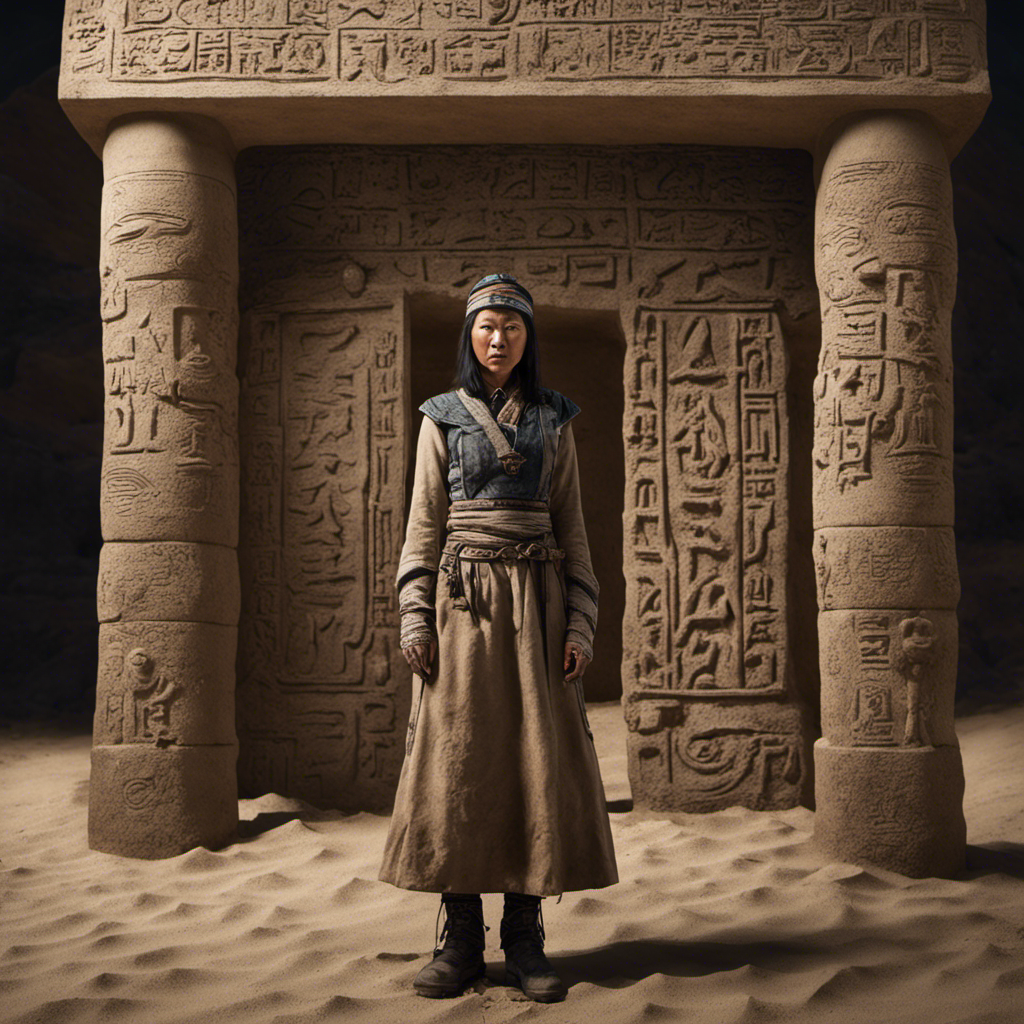

In [129]:
from IPython.display import display
img = image_generator.generate_image(all_image_prompts[0].prompt)
display(img)

- to avoid request throttle, split into small batches 

In [130]:

from itertools import islice

def split_batch(lst, batch_size=10):
    it = iter(lst)
    while True:
        batch_items = list(islice(it, batch_size))
        if not batch_items:
            break
        yield batch_items
        
images = []  
for batch_prompts in split_batch(all_image_prompts):
    rets = await image_gen_runner.abatch([obj.prompt for obj in batch_prompts])
    images.extend(rets)

{"text_prompts": [{"text": "A dramatic, cinematic portrait of Mei Ling, a renowned archaeologist, standing before an ancient tomb in the remote Gobi Desert, with a sense of wonder and determination on her face. The tomb is shrouded in mystery, with intricate hieroglyphic carvings and a sense of ancient power emanating from it. The scene is rendered in a painterly, chiaroscuro style inspired by classical Renaissance art, with dramatic lighting and rich, saturated colors. 4k, unreal engine, concept art"}], "cfg_scale": 7, "seed": 0, "steps": 50, "samples": 1, "style_preset": "photographic"}{"text_prompts": [{"text": "A cinematic, dramatic scene depicting Mei Ling, a determined doctoral student, standing before an ancient tomb, surrounded by her skilled team of grave robbers - Wang Peng, the agile former circus performer; Zhang Qiling, the master of disguise and deception; and Hei Bai, the hardened former special forces soldier. The image should convey a sense of mystery, intrigue, and th

In [131]:
len(images)

46

In [132]:
import os
def save_image_file(image, filename, folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
    image.save(os.path.join(folder, filename))
    print(f"image saved in {os.path.join(folder, filename)}")

In [133]:
img_fnames = []
folder='./images'
for i,img in enumerate(images):
    fname = str(i)+'.png'
    if img:
        save_image_file(img,fname,folder)
        img_fnames.append(os.path.join(folder, fname))
    else:
        img_fnames.append(None)
# img_fnames

image saved in ./images/0.png
image saved in ./images/1.png
image saved in ./images/2.png
image saved in ./images/3.png
image saved in ./images/4.png
image saved in ./images/5.png
image saved in ./images/6.png
image saved in ./images/7.png
image saved in ./images/8.png
image saved in ./images/9.png
image saved in ./images/10.png
image saved in ./images/11.png
image saved in ./images/12.png
image saved in ./images/13.png
image saved in ./images/14.png
image saved in ./images/15.png
image saved in ./images/16.png
image saved in ./images/17.png
image saved in ./images/18.png
image saved in ./images/19.png
image saved in ./images/20.png
image saved in ./images/21.png
image saved in ./images/22.png
image saved in ./images/23.png
image saved in ./images/24.png
image saved in ./images/25.png
image saved in ./images/26.png
image saved in ./images/27.png
image saved in ./images/28.png
image saved in ./images/29.png
image saved in ./images/30.png
image saved in ./images/31.png
image saved in ./i

- save to story pdf file

In [134]:
# story.images= img_fnames
story.images= images
# story_trans.images = images
len(images)

46

In [135]:
images

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>,
 <PIL.PngI

In [121]:
from IPython.display import display
[ display(img) for img in images if img != None]


[]

In [ ]:
# %pip install docx2pdf

In [136]:
from docx import Document
from docx.shared import Inches
from docx2pdf import convert
def save_image( image, folder='./images') -> str:
    """Save the image to a temporary file and return the file path."""
    image_path = f"temp_{hash(image.tobytes())}.png"
    filename = os.path.join(folder,image_path)
    image.save(filename)
    return filename


def save_as_docx(story, fname):
    document = Document()

    document.add_heading(story.page_title, 0)

    img_idx = 0
    for chapter in story.chapters:
        document.add_heading(chapter.chapter_title, level=1)
        for para in chapter.paragraphs:
            print(para)
            image = story.images[img_idx]
            img_idx += 1
            document.add_paragraph(para.content)

            # Add the image
            if image:
                document.add_picture(save_image(image), width=Inches(6))
            else:
                document.add_picture('placeholder.png', width=Inches(6))

    # Save the document
    document.save(fname)
    print(f'docx file saved as: {fname}')
    
    # Convert the Word document to PDF
    # pdf_path = f"{fname}.pdf"
    # convert(fname, pdf_path)
    # print(f'pdf file saved as: {pdf_path}')
    



In [137]:
save_as_docx(story,f'{story.page_title}.docx')

content='Mei Ling, a renowned archaeologist driven by a deep passion for uncovering the secrets of ancient civilizations, stood before an ancient tomb in the remote Gobi Desert. For years, she had heard whispers of a legendary relic hidden within, a relic that could unlock the mysteries of a long-lost culture. This discovery could cement her legacy as a pioneering scholar.'
content='Mei Ling had a personal connection to this tomb, as it had been the subject of her doctoral thesis years ago. She had never been able to let go of the mystery surrounding this site, and she was determined to uncover the truth, no matter the cost. To aid her in this endeavor, she had assembled a team of skilled grave robbers: Wang Peng, a former circus performer known for his incredible agility; Zhang Qiling, a master of disguise and deception; and Hei Bai, a former special forces soldier hardened by years of combat.'
content='As the team carefully excavated the tomb, they were struck by the sheer complexity

## 4. Concate all workflows

In [139]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    env_var: Optional[Annotated[Dict[str, any], operator.ior]]
    



- Write outline

In [140]:

async def create_outline(state:AgentState):
    steps = []
    async for event in outline_workflow.astream(state):
        steps.append(event)
        for key, value in event.items():
            print(f"Output from node '{key}':")
            print("---")
            print(value)
        print("\n---\n")
    env_var =  steps[-1]['generate_outline']['env_var']
    return {'env_var':{**env_var}}


- Write chapters

In [141]:
async def create_chapters(state:AgentState):
    env_var = state['env_var']
    outline = env_var['outline']
    characters = env_var['characters']
    write_all = RunnableLambda(write_all_chapters).bind(outline=outline,characters=characters)
    chaps = [ chatper for chatper in  outline.chapters]
    # write chatpers in parallel
    all_steps =  await write_all.abatch(chaps)
    
    ## merge all English chapters
    story = Story(page_title=outline.page_title,chapters=[s[0] for s in all_steps])
    
    
    
    return {'env_var':{**env_var,"story":story}}
    

- Create Translation

In [142]:

SRC_LANG = 'English'
DIST_LANG = 'Chinese'


translate_chapter_prompt = ChatPromptTemplate.from_messages( 
 [    
   (
        "system",
        role_config["translator"]+fc_desc,
        ),
    MessagesPlaceholder(variable_name="messages", optional=True),  
 ])

async def translate_chapter(chapter_obj: DetailChapter,source_lang:str,dist_lang:str):
    name = "translator"
    translate_chapter_chain = translate_chapter_prompt | llm | CustJsonOuputParser(verbose=True) |RunnableLambda(dict_to_obj).bind(target=DetailChapter)
    request  = HumanMessage(content=f"Here is the content to be translated:\n{chapter_obj.json()}",name=name)
    translation = await retry_call(translate_chapter_chain,{"source_lang":source_lang,"dist_lang":dist_lang,"messages":[request],"schema":DetailChapter.schema_json()})
    return translation

async def translate_node(state: AgentState):
    env_var = state['env_var']
    story = env_var['story']
    assert not story == None
    chaps = [ chatper for chatper in  story.chapters]
    translate_all = RunnableLambda(translate_chapter).bind(source_lang=SRC_LANG,dist_lang=DIST_LANG)
    all_chaps = await translate_all.abatch(chaps)
    ## merge all translated chapters
    story_trans = Story(page_title=story.page_title,chapters=all_chaps)
    return {'env_var':{**env_var,"story_trans":story_trans}}
    
    



- Generate Images

In [154]:
from itertools import islice

def split_batch(lst, batch_size=10):
    it = iter(lst)
    while True:
        batch_items = list(islice(it, batch_size))
        if not batch_items:
            break
        yield batch_items

async def generate_images_node(state:AgentState):
    env_var = state['env_var']
    story = env_var['story']
    gen_image_prompt_chain = gen_image_prompt | llm | CustJsonOuputParser(verbose=False) |RunnableLambda(dict_to_obj).bind(target=ImagePrompt)
    messages = [{"messages":[HumanMessage(content=para.content)],"schema":ImagePrompt.schema_json()} for chapter in story.chapters for para in chapter.paragraphs]
    
    ##Create prompt for image generation
    all_image_prompts = await gen_image_prompt_chain.abatch(messages)
    
    image_generator = ImageGenerator()
    
    ##Invoke image generation model
    image_gen_runner = RunnableLambda(image_generator.generate_image)
    images = []
    
    ## Split into small batchs to avoid request throttle
    for batch_prompts in split_batch(all_image_prompts):
        rets = await image_gen_runner.abatch([obj.prompt for obj in batch_prompts])
        images.extend(rets)
    
    return {'env_var':{**env_var,"images":images,"all_image_prompts":all_image_prompts}}


- Generate final file

In [155]:
async def generate_file_node(state:AgentState):
    env_var = state['env_var']
    story = env_var['story']
    story_trans = env_var['story_trans']
    images = env_var['images']
    story.images = images
    story_trans.images = images
    save_as_docx(story,f'{story.page_title}.docx')
    save_as_docx(story_trans,f'{story_trans.page_title}_trans.docx')
    return {'env_var':{**env_var,"story":story,"story_trans":story_trans}}
    
    

In [156]:
build_graph = StateGraph(AgentState)
build_graph.add_node("create_outline",create_outline)
build_graph.add_node("create_chapters",create_chapters)
build_graph.add_node("translate_node",translate_node)
build_graph.add_node("generate_images_node",generate_images_node)
build_graph.add_node("generate_file_node",generate_file_node)
build_graph.add_edge("create_outline","create_chapters")
build_graph.add_edge("create_chapters","translate_node")
build_graph.add_edge("translate_node","generate_images_node")
build_graph.add_edge("generate_images_node","generate_file_node")
build_graph.set_entry_point("create_outline")
build_graph.set_finish_point("generate_file_node")
workflow = build_graph.compile()


In [157]:

from IPython.display import Image

Image(workflow.get_graph().draw_png())


RuntimeError: error checking inheritance of <built-in function any> (type: builtin_function_or_method)

In [161]:
image_gen_runner = RunnableLambda(image_generator.generate_image)
imgs = image_gen_runner.batch(['a girl','a dog'])

{"text_prompts": [{"text": "a girl"}], "cfg_scale": 7, "seed": 0, "steps": 50, "samples": 1, "style_preset": "photographic"}{"text_prompts": [{"text": "a dog"}], "cfg_scale": 7, "seed": 0, "steps": 50, "samples": 1, "style_preset": "photographic"}



In [166]:
# image_generator = ImageGenerator()
# display(image_generator.generate_image('a dog'))

In [158]:
steps = []
init_state = {
    "env_var":{},
    "messages":[HumanMessage(content=f"Here is the topic:{topic}")]
}


In [159]:
async for event in workflow.astream(input=init_state):
    steps.append(event)
    for key, value in event.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

---generate_outline---
<thinking>
Okay, let's think through this step-by-step:
1. The user has provided a topic that combines elements from the "Grave Robbers' Chronicles" (盗墓笔记) and Liu Cixin's "The Three-Body Problem" (三体).
2. The key elements are:
   - Characters from the "Grave Robbers' Chronicles"
   - The background/setting of "The Three-Body Problem", specifically the arrival of the Trisolarans' sophons (智子) on Earth
3. This suggests a new science fiction/fantasy story that takes place in the world of "The Three-Body Problem", but features characters and plot elements from the "Grave Robbers' Chronicles".
4. I will need to carefully craft an outline that seamlessly integrates these two different fictional universes into a cohesive and compelling narrative.
</thinking>

<answer>
{
  "page_title": "The Grave Robbers' Odyssey",
  "chapters": [
    {
      "chapter_title": "The Sophon's Arrival",
      "description": "The story begins as the mysterious Trisolarans' sophons descend u

In [160]:
steps[-1]

{'generate_file_node': {'env_var': {'outline': Outline(page_title="The Grave Robbers' Odyssey", chapters=[Chapter(chapter_title="The Sophon's Arrival", description="The story begins as the mysterious Trisolarans' sophons descend upon Earth, sowing chaos and confusion among humanity. In the midst of this global crisis, a group of seasoned grave robbers - Wang Xuebing, Fatty, and Er Bao - are drawn into the unfolding events. They are approached by Mei Ling, a fierce rebel fighter from the resistance movement, who seeks their help in uncovering the Trisolarans' weaknesses and fighting against the invasion."), Chapter(chapter_title='The Call to Adventure', description="Motivated by the promise of ancient relics that may hold the key to understanding the Trisolarans, the grave robbers assemble a team that includes Zhao Qing, a brilliant historian and archaeologist, and Zhang Hao, a highly decorated military commander leading a specialized team of operatives. Together, they set out on a peri